<a href="https://colab.research.google.com/github/Aabhash012/Twitter/blob/main/Twitter_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Step - 1 :** *Importing Necesaary Libraries and Datasets*

### **Step - 1.1 :** *Importing Necesaary Packages & Libraries*

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score


# Keras
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('omw-1.4')

# Word2vec
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


# Utility
import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime

# WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### **Step - 1.2 :** *Importing Dataset*

In [3]:
  # df = pd.read_csv("../input/twitter-sentiment-dataset/Twitter_Data.csv")
df=pd.read_csv("Twitter_Data.csv")
df1 = df

In [4]:
df.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
df = df[df.category != 0.0]

## **Step - 2 :** *Data Pre-processing*

### **Step - 2.1 :** Variable Declaration

In [6]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107767 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107765 non-null  object 
 1   category    107760 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [7]:
# Varaibles related to dataset
DATASET_COLUMNS = ["clean_text", "category"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# Parameters for WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Parameters related to KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# Variable specific to SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Variables for Exporting purpose
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# MISC

plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

### **Step - 2.2 :** Null Values Identification and Treatment

In [8]:
# Confirming presence of missing values in each variable
df.isnull().sum()


clean_text    2
category      7
dtype: int64

In [9]:
df.dropna(how='any', inplace=True) # Removed these rows as the count is small and will not affect overall modelling
df.isnull().sum()

clean_text    0
category      0
dtype: int64

### **Step - 2.3 :** Label Encoding

In [10]:
decode_map = {-1.0: "NEGATIVE", 1.0: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
%%time
df.category = df.category.apply(lambda x: decode_sentiment(x))

CPU times: user 43 ms, sys: 2.95 ms, total: 45.9 ms
Wall time: 45.7 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

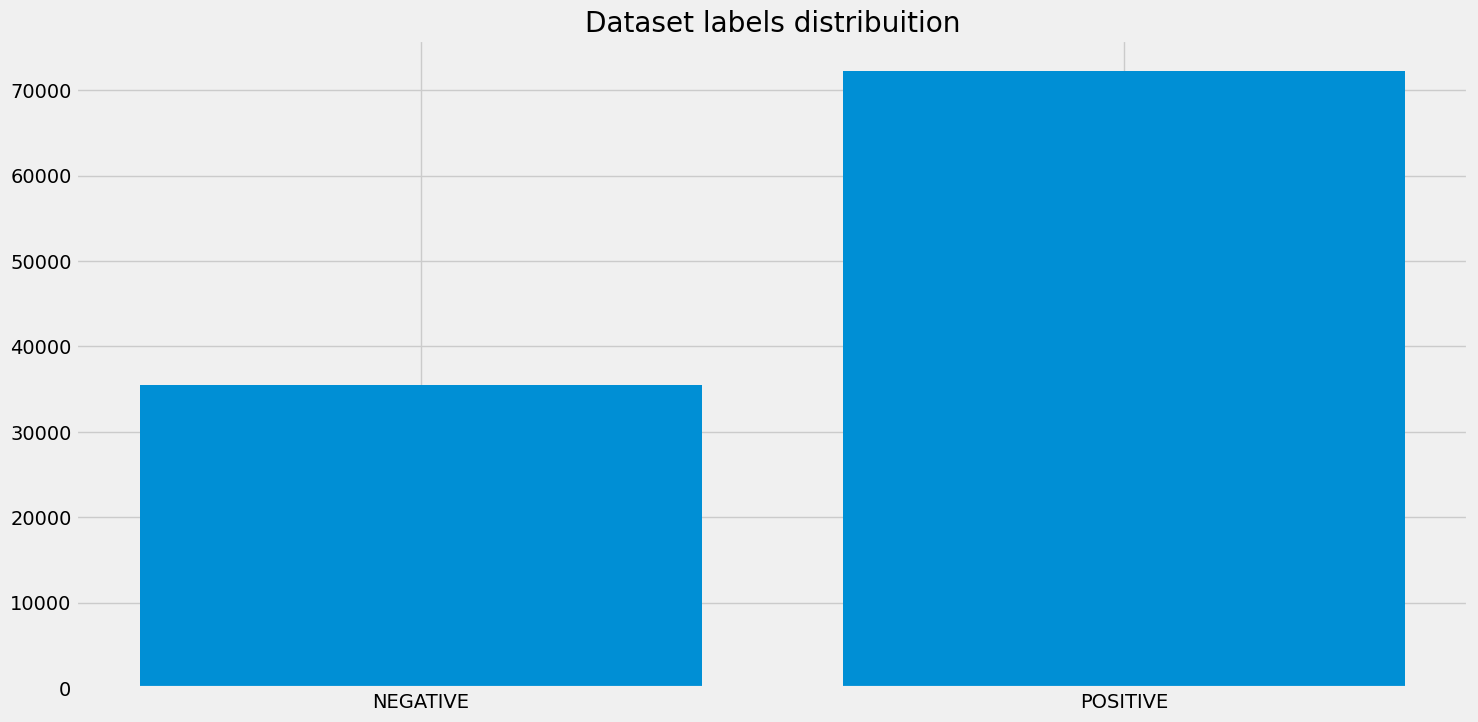

In [12]:
category_cnt = Counter(df.category)

plt.figure(figsize=(16,8))
plt.bar(category_cnt.keys(), category_cnt.values())
plt.title("Dataset labels distribuition")

In [13]:
# Including Stopwords and exclusing 'not' related stopwords

stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)

stemmer = SnowballStemmer("english")

In [14]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# Applying helper functions

df['mod_text'] = df['clean_text'].apply(lambda x: remove_URL(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_emoji(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_html(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_punct(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_quotes(x))
df.head()

,clean_text,category,mod_text
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...


In [15]:
# Tokenizing the tweet base texts.

df['tokenized'] = df['mod_text'].apply(word_tokenize)

df.head()

,clean_text,category,mod_text,tokenized
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,..."


In [16]:
# Lower casing clean text.

df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

df.head()

,clean_text,category,mod_text,tokenized,lower
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,..."


In [17]:
# Removing stopwords.

df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])

df.head()


,clean_text,category,mod_text,tokenized,lower,stopwords_removed
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor..."


In [18]:
# Applying part of speech tags.

df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

df.head()

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ..."


In [19]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df.head()

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove..."
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),..."
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c..."
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl..."
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa..."


In [20]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove...","[modi, promise, minimum, government, maximum, ...",modi promise minimum government maximum govern...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),...","[say, vote, modi, welcome, bjp, tell, rahul, m...",say vote modi welcome bjp tell rahul main camp...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c...","[ask, supporter, prefix, chowkidar, name, modi...",ask supporter prefix chowkidar name modi great...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa...","[upcoming, election, india, saga, go, importan...",upcoming election india saga go important pair...


In [21]:
print("Total Rows =", len(df.clean_text))

Total Rows = 107758


In [22]:
df.head()

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove...","[modi, promise, minimum, government, maximum, ...",modi promise minimum government maximum govern...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),...","[say, vote, modi, welcome, bjp, tell, rahul, m...",say vote modi welcome bjp tell rahul main camp...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c...","[ask, supporter, prefix, chowkidar, name, modi...",ask supporter prefix chowkidar name modi great...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa...","[upcoming, election, india, saga, go, importan...",upcoming election india saga go important pair...


In [23]:
df_mod = df[["lemma_str", "category"]]
df_mod.head()

,lemma_str,category
0,modi promise minimum government maximum govern...,NEGATIVE
2,say vote modi welcome bjp tell rahul main camp...,POSITIVE
3,ask supporter prefix chowkidar name modi great...,POSITIVE
4,answer among powerful world leader today trump...,POSITIVE
8,upcoming election india saga go important pair...,POSITIVE


### **Step - 2.4 :** Train-Test Split

In [24]:
df_train, df_test = train_test_split(df_mod, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 86206
TEST size: 21552


## **Step - 3 :** *Word Cloud Analysis*

In [25]:
def plot_wordcloud(text, mask, title, title_size, figure_size=(24.0,16.0), image_color=False):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stop_words,
                    max_words = 140,
                    max_font_size = 120,
                    random_state = 42,
                    mask = mask,
    ).generate(str(mostcommon))

    ########

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

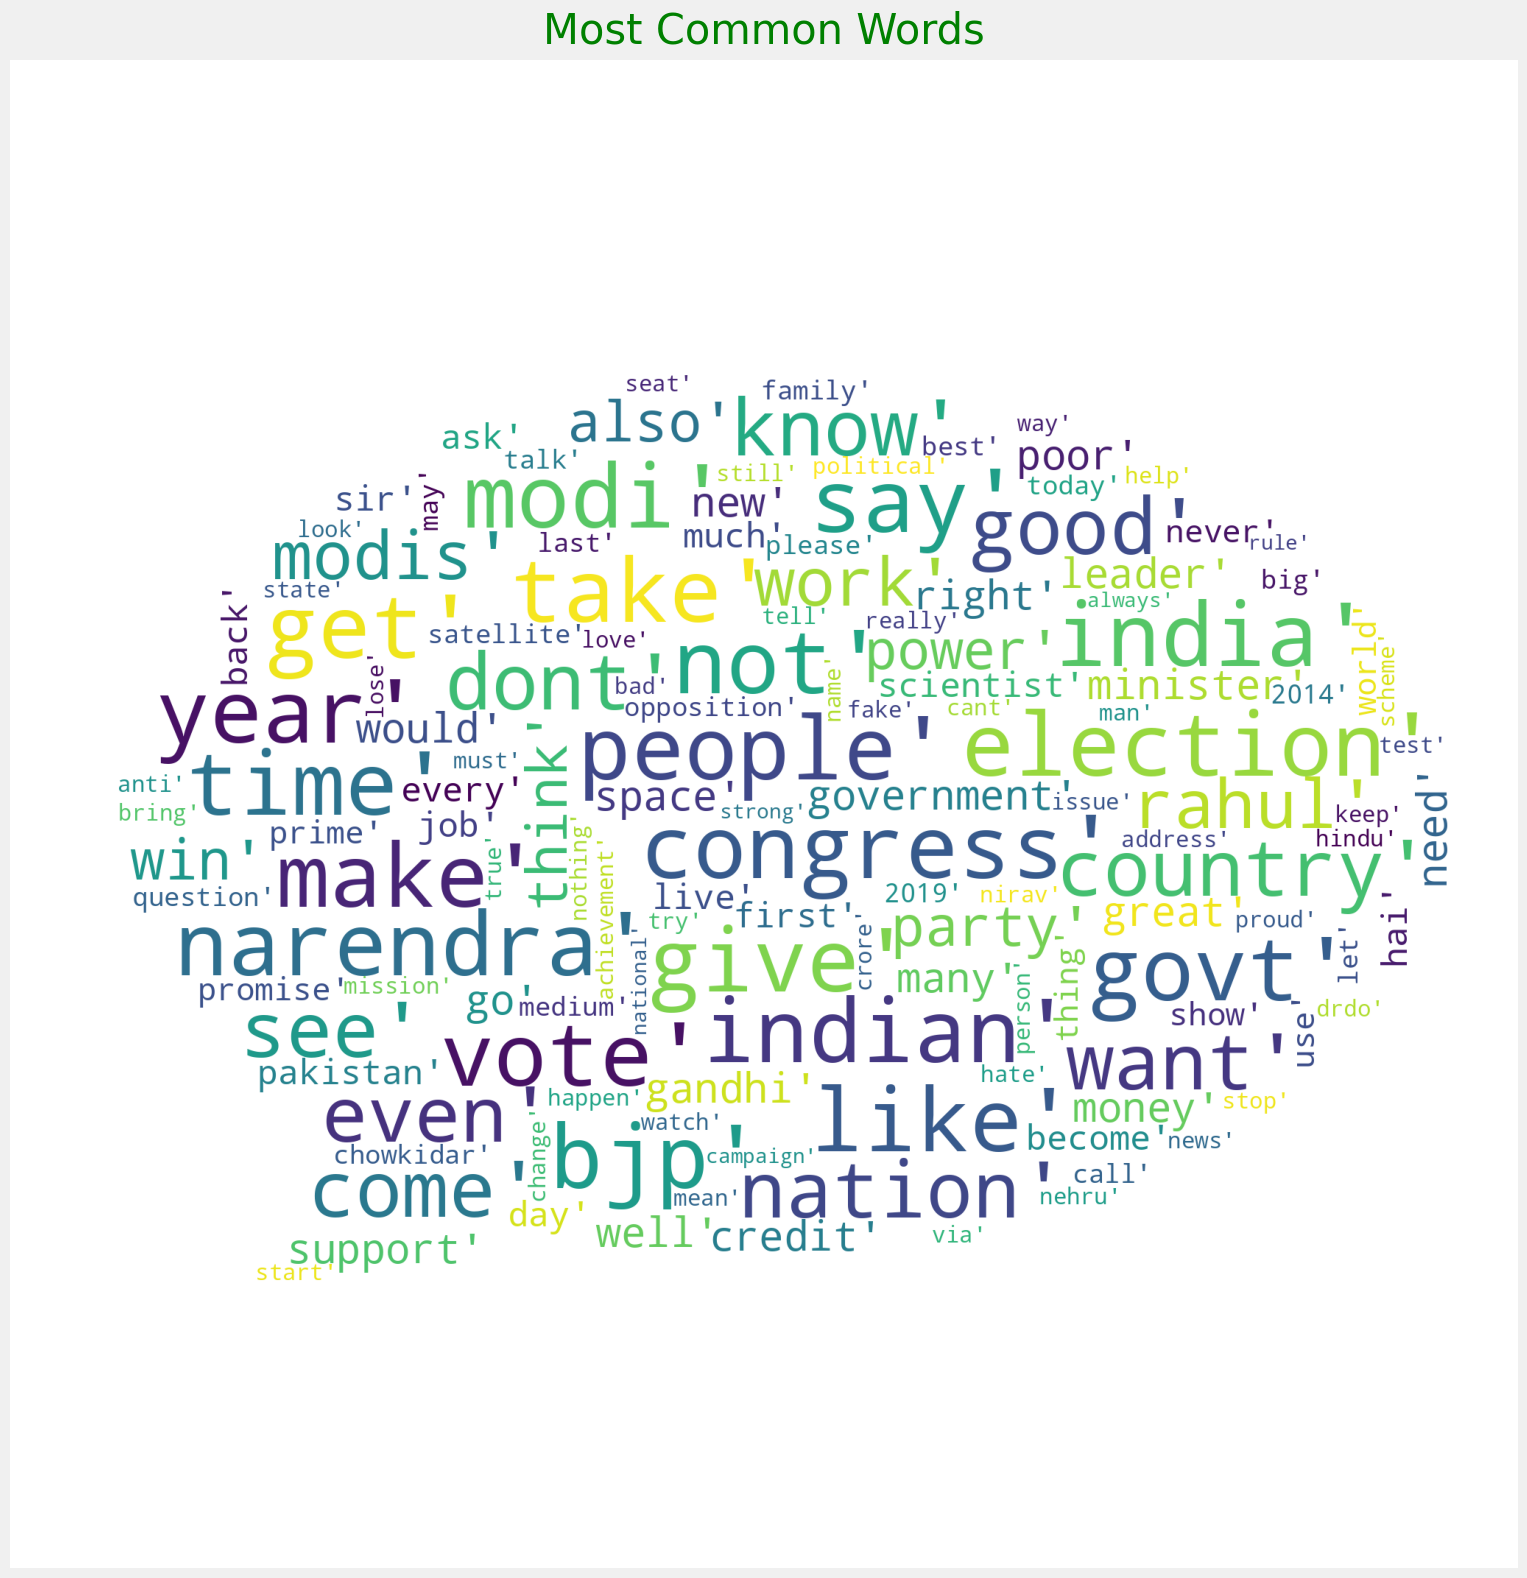

In [26]:
comments_mask = np.array(Image.open('./comment.png'))
plot_wordcloud(df['lemmatized'], comments_mask,
               'Most Common Words',
               title_size=30)

## **Step - 4 :** *Word2Vec Analysis*

### **Step - 4.1 :** Corpus Creation

In [27]:
%%time
documents = [text.split() for text in df_train.lemma_str]

CPU times: user 275 ms, sys: 48.5 ms, total: 323 ms
Wall time: 367 ms


### **Step - 4.2 :** Word2Vec Model Creation

In [28]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

### **Step - 4.3 :** Vocab Creation

In [29]:

w2v_model.build_vocab(documents)

In [30]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 8353


### **Step - 4.4 :** Training Word2Vec Model

In [31]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 3min 3s, sys: 671 ms, total: 3min 4s
Wall time: 1min 49s


(37099708, 45364480)

### **Step - 4.5 :** Word2Vec Model Testing

In [32]:
w2v_model.wv.most_similar("bjp")

[('cadre', 0.45710867643356323),
 ('trs', 0.4533940851688385),
 ('party', 0.4491231441497803),
 ('ncp', 0.4000566303730011),
 ('congress', 0.39781808853149414),
 ('jds', 0.3930608630180359),
 ('karnataka', 0.38234108686447144),
 ('coalition', 0.37574106454849243),
 ('rjd', 0.36140376329421997),
 ('dmk', 0.3581215441226959)]

## **Step - 5 :** *Sentiment Analysis using Deep-Learning Model*

### **Step - 5.1 :** Token and Vocab Creation

In [33]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.lemma_str)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 70297
CPU times: user 2.04 s, sys: 88.8 ms, total: 2.13 s
Wall time: 2.08 s


In [34]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.lemma_str), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.lemma_str), maxlen=SEQUENCE_LENGTH)

CPU times: user 1.97 s, sys: 41.9 ms, total: 2.01 s
Wall time: 2.02 s


### **Step - 5.2 :** Label Encoding

In [35]:
labels = df_train.category.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [36]:
encoder = LabelEncoder()
encoder.fit(df_train.category.tolist())

y_train = encoder.transform(df_train.category.tolist())
y_test = encoder.transform(df_test.category.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (86206, 1)
y_test (21552, 1)


In [37]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (86206, 300)
y_train (86206, 1)

x_test (21552, 300)
y_test (21552, 1)


In [38]:
y_train[:10]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]])

### **Step - 5.3 :** Embedding Layer Creation

In [39]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(70297, 300)


In [40]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### **Step - 5.4 :** Model Creation - LSTM

In [41]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          21089100  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 21,249,601
Trainable params: 160,501
Non-trainable params: 21,089,100
_________________________________________________________________


### **Step - 5.5 :** Compiling Model

In [42]:

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### **Step - 5.6 :** Callback Creation

In [43]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### **Step - 5.7 :** Model Training

In [44]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
76/76 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.6824 

76/76 [==============================] - 1105s 14s/step - loss: 0.5861 - accuracy: 0.6824 - val_loss: 0.4828 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 2/10
76/76 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7375 

76/76 [==============================] - 1082s 14s/step - loss: 0.5145 - accuracy: 0.7375 - val_loss: 0.4387 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 3/10
76/76 [==============================] - ETA: 0s - loss: 0.5111 - accuracy: 0.7376 

76/76 [==============================] - 1090s 14s/step - loss: 0.5111 - accuracy: 0.7376 - val_loss: 0.4200 - val_accuracy: 0.8014 - lr: 0.0010
Epoch 4/10
76/76 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.7736 

76/76 [==============================] - 1088s 14s/step - loss: 0.4624 - accuracy: 0.7736 - val_loss: 0.3812 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 5/10
76/76 [==============================] - ETA: 0s - loss: 0.4313 - accuracy: 0.7937 

76/76 [==============================] - 1089s 14s/step - loss: 0.4313 - accuracy: 0.7937 - val_loss: 0.3590 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 6/10
76/76 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8060 

76/76 [==============================] - 1084s 14s/step - loss: 0.4115 - accuracy: 0.8060 - val_loss: 0.3483 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 7/10
76/76 [==============================] - ETA: 0s - loss: 0.3971 - accuracy: 0.8164 

76/76 [==============================] - 1069s 14s/step - loss: 0.3971 - accuracy: 0.8164 - val_loss: 0.3371 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 8/10
76/76 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.8232 

76/76 [==============================] - 1083s 14s/step - loss: 0.3850 - accuracy: 0.8232 - val_loss: 0.3325 - val_accuracy: 0.8507 - lr: 0.0010
Epoch 9/10
76/76 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8280 

76/76 [==============================] - 1087s 14s/step - loss: 0.3751 - accuracy: 0.8280 - val_loss: 0.3187 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 10/10
76/76 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8328 

76/76 [==============================] - 1091s 14s/step - loss: 0.3677 - accuracy: 0.8328 - val_loss: 0.3174 - val_accuracy: 0.8628 - lr: 0.0010
CPU times: user 4h 54min 50s, sys: 12min 51s, total: 5h 7min 41s
Wall time: 3h 1min 26s


### **Step - 5.8 :** Model Evaluation

In [45]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

22/22 [==============================] - 67s 3s/step - loss: 0.3152 - accuracy: 0.8611

ACCURACY: 0.8611266016960144
LOSS: 0.31518810987472534
CPU times: user 1min 39s, sys: 7.19 s, total: 1min 46s
Wall time: 1min 22s


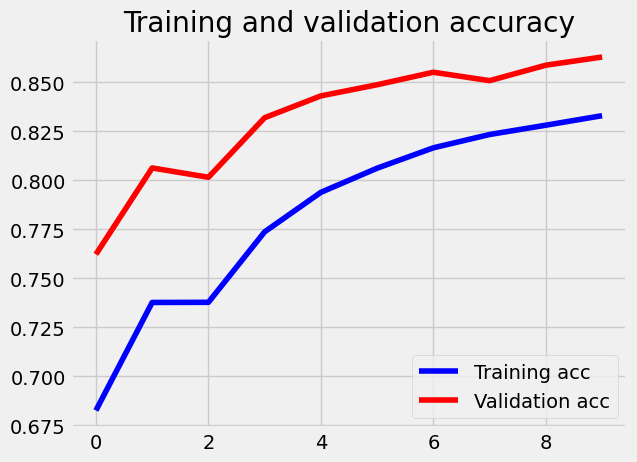

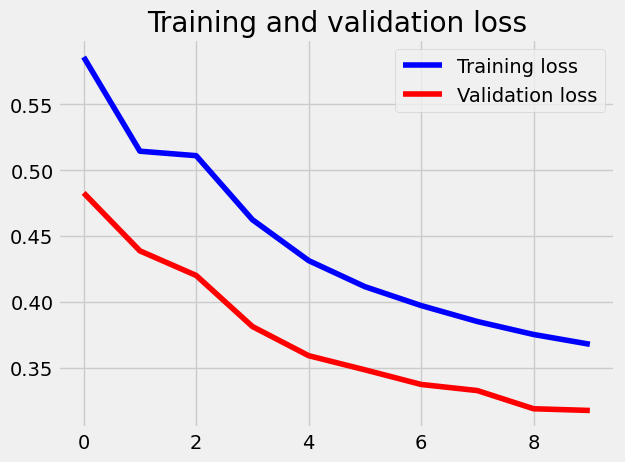

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL ### Whatever not coming in negative and positive sentiments has been considered as neutral
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [48]:
def predict(clean_text, include_neutral=True):
    start_at = time.time()
    # Tokenize clean_text
    x_test = pad_sequences(tokenizer.texts_to_sequences([clean_text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [49]:
predict("I love the music")

1/1 [==============================] - 1s 686ms/step


{'label': 'POSITIVE',
 'score': 0.9953271746635437,
 'elapsed_time': 0.767552375793457}

In [50]:
predict("I have nothing to lose")

1/1 [==============================] - 0s 78ms/step


{'label': 'NEUTRAL',
 'score': 0.5488256216049194,
 'elapsed_time': 0.1360321044921875}

In [51]:
# 5. Test and Gradio
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [52]:
import tensorflow as tf
import gradio as gr

In [53]:
model.save('toxicity89.h5')

In [54]:
model = tf.keras.models.load_model('toxicity89.h5')

In [55]:
input_str = ('hey i freaken hate you!')

In [56]:
res = predict(input_str)

1/1 [==============================] - 2s 2s/step


In [57]:
res

{'label': 'NEGATIVE',
 'score': 0.005526405293494463,
 'elapsed_time': 2.34269380569458}

In [58]:
def score_comment(comment):
    results = predict(comment)

    text = predict(comment)['label']

    return text

In [59]:
res = predict(input_str)

1/1 [==============================] - 0s 80ms/step


In [60]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [61]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://40b7b8cfee38b2cf36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### **Step - 5.10 :** Creating Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.category)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.category.unique(), title="Confusion matrix")
plt.show()

### **Step - 5.11 :** Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### **Step - 5.12 :** Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### **Step - 5.13 :** Saving Model for future use

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)